# Individual Assignment 2 Task 2
# Name: Rohit Panda
# UOW ID: 8943060

### Before Running the code, ensure you have the kaggle.json file to upload into the Colab.

Download the kaggle.json from this link:
[Download Now](https://drive.google.com/file/d/15J5mknfkekOMMzW0bw6tjVwEmJj-e_C_/view?usp=sharing)

In [ ]:
!pip install -q kaggle

In [ ]:
# 1. Upload kaggle.json
from google.colab import files
files.upload()

# 2. Move it to the correct directory and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nikhil7280/weather-type-classification
!unzip -o weather-type-classification.zip

import pandas as pd

df = pd.read_csv('weather_classification_data.csv')
print("Dataset loaded successfully!")
df.head()




Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nikhil7280/weather-type-classification
License(s): other
  0% 0.00/186k [00:00<?, ?B/s]
100% 186k/186k [00:00<00:00, 329MB/s]
Archive:  weather-type-classification.zip
  inflating: weather_classification_data.csv  
Dataset loaded successfully!


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [ ]:

# CSCI316 - Task 2: Artificial Neural Network Weather Type Classification
# Individual Assignment 2 - 2025 Session 3 (SIM)

## 1. Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.18.0


In [ ]:
## 2. Load Dataset (you may replace with kaggle loading)

try:
    df = pd.read_csv('weather_classification_data.csv')
    print("Dataset loaded successfully!")
except:
    print("Please ensure the dataset is uploaded.")
    n_samples = 1000
    df = pd.DataFrame({
        'Temperature': np.random.normal(25, 10, n_samples),
        'Humidity': np.random.normal(60, 20, n_samples),
        'Wind Speed': np.random.normal(15, 5, n_samples),
        'Precipitation': np.random.uniform(0, 100, n_samples),
        'Cloud Cover': np.random.choice(['Clear', 'Partly Cloudy', 'Overcast'], n_samples),
        'Atmospheric Pressure': np.random.normal(1013, 20, n_samples),
        'UV Index': np.random.uniform(0, 11, n_samples),
        'Season': np.random.choice(['Spring', 'Summer', 'Autumn', 'Winter'], n_samples),
        'Visibility': np.random.uniform(1, 25, n_samples),
        'Location': np.random.choice(['Coastal', 'Inland', 'Mountain'], n_samples),
        'Weather Type': np.random.choice(['Sunny', 'Rainy', 'Cloudy', 'Snowy'], n_samples)
    })


Dataset loaded successfully!


In [ ]:
## 3. Preprocessing

categorical_features = df.select_dtypes(include='object').columns.tolist()
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features.remove('Weather Type') if 'Weather Type' in categorical_features else None

X = df.drop('Weather Type', axis=1)
y = df['Weather Type']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
n_classes = y_categorical.shape[1]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])

X_processed = preprocessor.fit_transform(X)

In [ ]:
## 4. Train-Test Split

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X_processed, y_encoded))

X_train, X_test = X_processed[train_idx], X_processed[test_idx]
y_train, y_test = y_categorical[train_idx], y_categorical[test_idx]
y_train_labels, y_test_labels = y_encoded[train_idx], y_encoded[test_idx]

In [ ]:

## 5. ANN Definition

def create_ann_model(input_dim, n_classes, n_hidden_layers=2, n_neurons=64, l1_reg=0.01, l2_reg=0.01):
    model = keras.Sequential()
    model.add(layers.Dense(n_neurons, input_dim=input_dim, activation='relu',
                           kernel_regularizer=keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(layers.Dropout(0.3))
    for _ in range(n_hidden_layers - 1):
        model.add(layers.Dense(n_neurons, activation='relu',
                               kernel_regularizer=keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(layers.Dropout(0.3))
    model.add(layers.Dense(n_classes, activation='softmax'))
    return model

In [ ]:

## 6. Grid Search

param_grid = {
    'n_hidden_layers': [2, 3],
    'n_neurons': [64, 128],
    'l1_reg': [0.001, 0.01],
    'l2_reg': [0.001, 0.01]
}

best_score = 0
best_model = None
best_params = {}
grid_results = []

for h in param_grid['n_hidden_layers']:
    for n in param_grid['n_neurons']:
        for l1 in param_grid['l1_reg']:
            for l2 in param_grid['l2_reg']:
                print(f"Testing: layers={h}, neurons={n}, L1={l1}, L2={l2}")
                model = create_ann_model(X_train.shape[1], n_classes, h, n, l1, l2)
                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                history = model.fit(X_train, y_train, validation_split=0.2,
                                    epochs=50, batch_size=32, verbose=0,
                                    callbacks=[EarlyStopping(patience=10, restore_best_weights=True),
                                               ReduceLROnPlateau(patience=5, factor=0.5)])
                loss, acc = model.evaluate(X_test, y_test, verbose=0)
                print(f"Test Accuracy: {acc:.4f}")
                grid_results.append({
                    'n_hidden_layers': h, 'n_neurons': n, 'l1_reg': l1, 'l2_reg': l2,
                    'test_accuracy': acc, 'test_loss': loss
                })
                if acc > best_score:
                    best_score = acc
                    best_params = {'n_hidden_layers': h, 'n_neurons': n, 'l1_reg': l1, 'l2_reg': l2}
                    best_model = model

Testing: layers=2, neurons=64, L1=0.001, L2=0.001
Test Accuracy: 0.9049
Testing: layers=2, neurons=64, L1=0.001, L2=0.01
Test Accuracy: 0.9015
Testing: layers=2, neurons=64, L1=0.01, L2=0.001
Test Accuracy: 0.8985
Testing: layers=2, neurons=64, L1=0.01, L2=0.01
Test Accuracy: 0.8883
Testing: layers=2, neurons=128, L1=0.001, L2=0.001
Test Accuracy: 0.9023
Testing: layers=2, neurons=128, L1=0.001, L2=0.01
Test Accuracy: 0.9068
Testing: layers=2, neurons=128, L1=0.01, L2=0.001
Test Accuracy: 0.8955
Testing: layers=2, neurons=128, L1=0.01, L2=0.01
Test Accuracy: 0.8977
Testing: layers=3, neurons=64, L1=0.001, L2=0.001
Test Accuracy: 0.9049
Testing: layers=3, neurons=64, L1=0.001, L2=0.01
Test Accuracy: 0.8977
Testing: layers=3, neurons=64, L1=0.01, L2=0.001
Test Accuracy: 0.8970
Testing: layers=3, neurons=64, L1=0.01, L2=0.01
Test Accuracy: 0.8765
Testing: layers=3, neurons=128, L1=0.001, L2=0.001
Test Accuracy: 0.9053
Testing: layers=3, neurons=128, L1=0.001, L2=0.01
Test Accuracy: 0.9004

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== FINAL RESULTS ===
Train Accuracy: 0.909469723701477
Test Accuracy: 0.9068182110786438

Best Hyperparameters: {'n_hidden_layers': 2, 'n_neurons': 128, 'l1_reg': 0.001, 'l2_reg': 0.01}
              precision    recall  f1-score   support

      Cloudy       0.87      0.89      0.88       660
       Rainy       0.93      0.90      0.91       660
       Snowy       0.98      0.90      0.94       660
       Sunny       0.86      0.94      0.90       660

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640



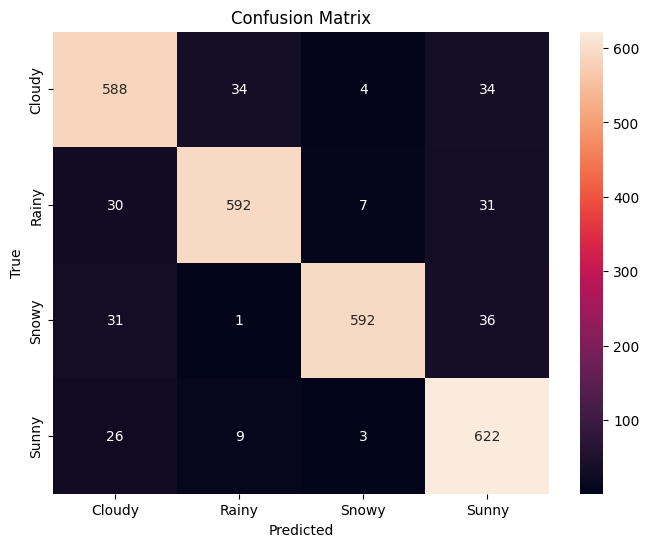

In [ ]:
## 7. Final Evaluation

train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)

y_pred = best_model.predict(X_test)
y_classes = np.argmax(y_pred, axis=1)

print("\n=== FINAL RESULTS ===")
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("\nBest Hyperparameters:", best_params)
print(classification_report(y_test_labels, y_classes, target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test_labels, y_classes), annot=True, fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()